## BOAR for TrPL fitting
Version 1.0.0
(c) Vincent M. Le Corre, Larry Lueer, i-MEET 2021-2023

This notebook is made to use BOAR for fitting transient photoluminescence (TrPL) data with rate equations.

Here we use the following rate equations:

$$\frac{dn}{dt}  = G - k_{trap} n (Bulk_{tr} - n_t) - k_{direct} n (p + p_0)$$
$$\frac{dn_t}{dt}= k_{trap} n (Bulk_{tr} - n_t) - k_{detrap} n_t (p + p_0)$$
$$\frac{dp}{dt} = G - k_{detrap} n_t (p + p_0) - k_{direct} n (p + p_0)$$

where $n$ and $p$ are the electron and hole charge carrier densities, $G$ is the generation rate in m&#8315;&#179; s&#8315;&#185;, k<sub>trap</sub> and k<sub>detrap</sub> are the trapping and detraping rates in m&#179; s&#8315;&#185;, and k<sub>direct</sub> is the bimolecular/band-to-bad recombination rate in m&#179; s&#8315;&#185;.


In [1]:
# Activate matplotlib widgets
# %matplotlib inline
# comment the next line if you are on the jupyterhub server
# %matplotlib widget 
# %matplotlib notebook

# Import libraries
import sys,os
from numpy.random import default_rng
import warnings
warnings.filterwarnings('ignore') # comment this out to see warnings

# Import boar
# import one folder up
sys.path.append('../') # comment out if the Notebook is in the Notebooks folder
from boar import *


In [2]:
# Define the path to the data directory
curr_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(curr_dir, '../')) # path to the parent directory
res_dir = os.path.join(parent_dir,'temp') # path to the results directory

### Define the free parameters to be optimized

In [3]:
# define Fitparameters
# create fit parameters for the various processes we have to consider
True_values = {'kdirect': 1e-17, 'ktrap': 5e-18, 'kdetrap':1e-18,'Bulk_tr':1e23,'p_0':0e19, 'QE': 0.9, 'I_PL': 1e-32, 'N0': 1.04103e24}

params = []
kdirect = Fitparam(name = 'kdirect', val =  True_values['kdirect'], relRange = 1, range_type = 'log',
            lim_type = 'relative',optim_type='log', display_name = 'k$_2$',unit='m$^{3}$ s$^{-1}$')
params.append(kdirect)
ktrap = Fitparam(name = 'ktrap', val = True_values['ktrap'] , relRange = 1, range_type = 'log',
            lim_type = 'relative',optim_type='log', display_name = 'k$_{trap}$',unit='m$^{3}$ s$^{-1}$')
params.append(ktrap)
kdetrap = Fitparam(name = 'kdetrap', val =  True_values['kdetrap'], relRange = 1, range_type = 'log',
            lim_type = 'relative',optim_type='log', display_name = 'k$_{detrap}$',unit='m$^{3}$ s$^{-1}$')
params.append(kdetrap)
Bulk_tr = Fitparam(name = 'Bulk_tr', val =  True_values['Bulk_tr'], relRange = 1, range_type = 'log',
            lim_type = 'relative',optim_type='log', display_name = 'N$_T$',unit='m$^{-3}$')
params.append(Bulk_tr)
p_0 = Fitparam(name = 'p_0', val =  True_values['p_0'], relRange = 0, range_type = 'log',
            lim_type = 'relative',optim_type='log', display_name = 'p$_0$',unit='m$^{-3}$')
params.append(p_0)
QE = Fitparam(name = 'QE', val =  True_values['QE'], lims = [0.02, 1], relRange = 0, range_type = 'linear',
            lim_type = 'absolute',optim_type = 'linear', display_name = 'QE',unit='%')
params.append(QE)
I_PL = Fitparam(name = 'I_PL', val =  True_values['I_PL'], lims = [1e-33, 1e-31], relRange = 0, range_type = 'linear',
            lim_type = 'absolute',optim_type = 'linear', axis_type='log',display_name= 'I$_{PL}$',unit='a.u.')
params.append(I_PL)
N0 = Fitparam(name = 'N0', val =  True_values['N0'], lims = [5e21, 5e22], relRange = 0, range_type = 'log',
            lim_type = 'absolute',optim_type = 'log', axis_type='log',display_name= 'N$_0$',unit='m$^{-3}$')
params.append(N0)


### Prepare fake data for fitting
In the next block we create some fake data with some random noise and plot it.

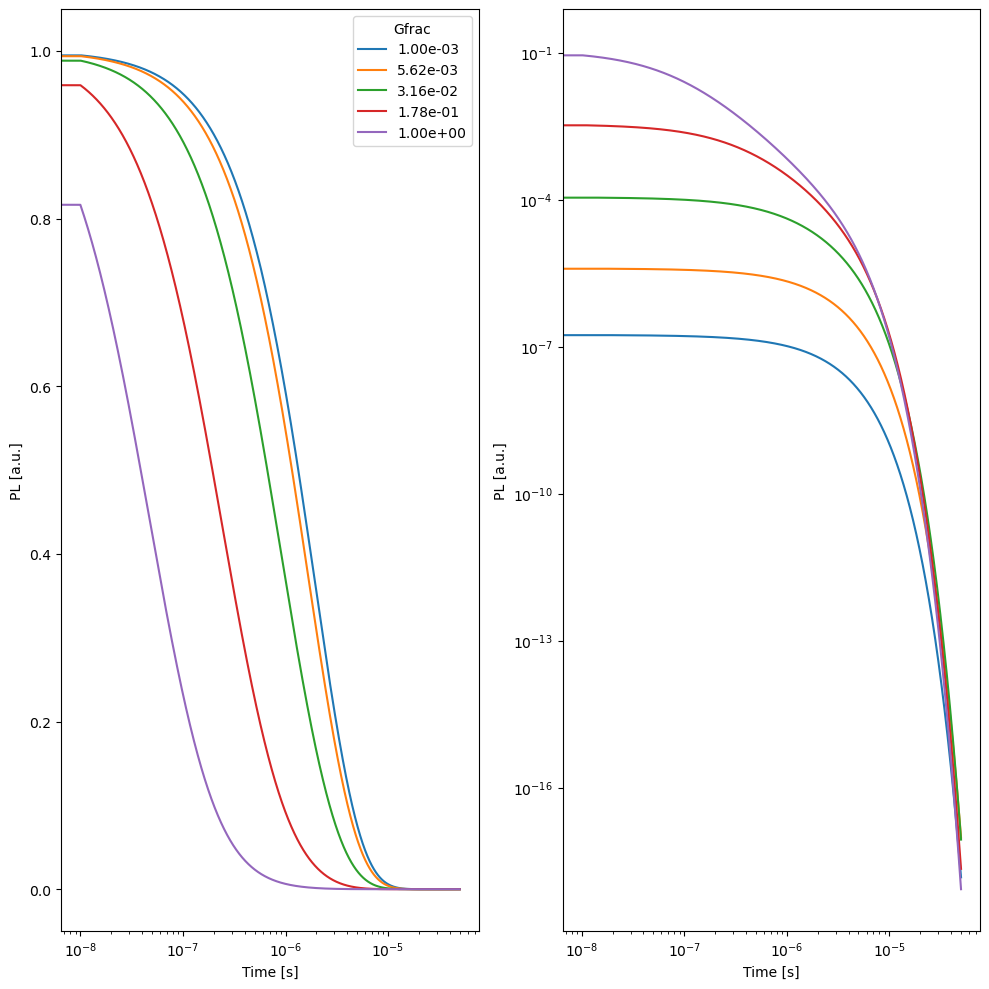

In [4]:
# Make fake data
rng = default_rng()
noise = 1e3 # noise level
fpu = 1e3 # pump frequency in Hz
background = 0e20 # background pump density in m^-3

# create a pump pulse
x1 = np.geomspace(1e-8, 50e-6, num=10000)
#add 0 to the beginning of the pump pulse
x1 = np.insert(x1,0,0)
X_dimensions = ['t','Gfrac']

X,y,weight = [],[],[]
trPL = TrPL_agent()
trPL.trPL_model = partial(Bimolecular_Trapping_Detrapping_equation, solver_func='odeint', method='Radau')
trPL.pump_params['fpu'] = fpu
trPL.pump_params['background'] = background

Gfracs = np.geomspace(1e-3,1,endpoint=True,num=5)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
for Gfrac in Gfracs:
    X1 =  [[xx, Gfrac] for xx in x1]
    X = X +  X1
    y1 = trPL.trPL(np.asarray(X1), params, X_dimensions=X_dimensions,take_log=True) 
    y1 = y1 
    y = y + list(y1)
    weight = weight + list(1/(np.abs(max(y1)*np.ones(len(y1))))) #
    ax1.semilogx(x1,10**y1/max(10**y1),label=f'{Gfrac:.2e}')
    ax2.loglog(x1,10**y1)


ax1.set_ylabel('PL [a.u.]')
ax1.set_xlabel('Time [s]')
ax1.legend(title='Gfrac')

ax2.set_ylabel('PL [a.u.]')
ax2.set_xlabel('Time [s]')
plt.tight_layout()

X = np.array(X)
y = np.array(y)
weight = np.array(weight)
weight/=np.mean(weight)
weight[weight>10]=10    


### Start the optimization

Scaling runs for target 0:   0%|          | 0/1 [00:00<?, ?it/s]

Starting with initial points


Initial points:   0%|          | 0/4 [00:00<?, ?it/s]

Initial points done in 6.28 s
Starting with BO


BO runs:   0%|          | 0/38 [00:00<?, ?it/s]

BO done in 493.84 s
Ground truth minimum at: [-17.112642919378466, -17.53612760155863, -18.001599733204248, 23.225004808091786] with function value: 0.0016781845171503886
Minimum of surrogate function: [-17.091955317201442, -17.36113334155393, -18.190154043320664, 23.084805849957494] with function value 0.0006396484807291714


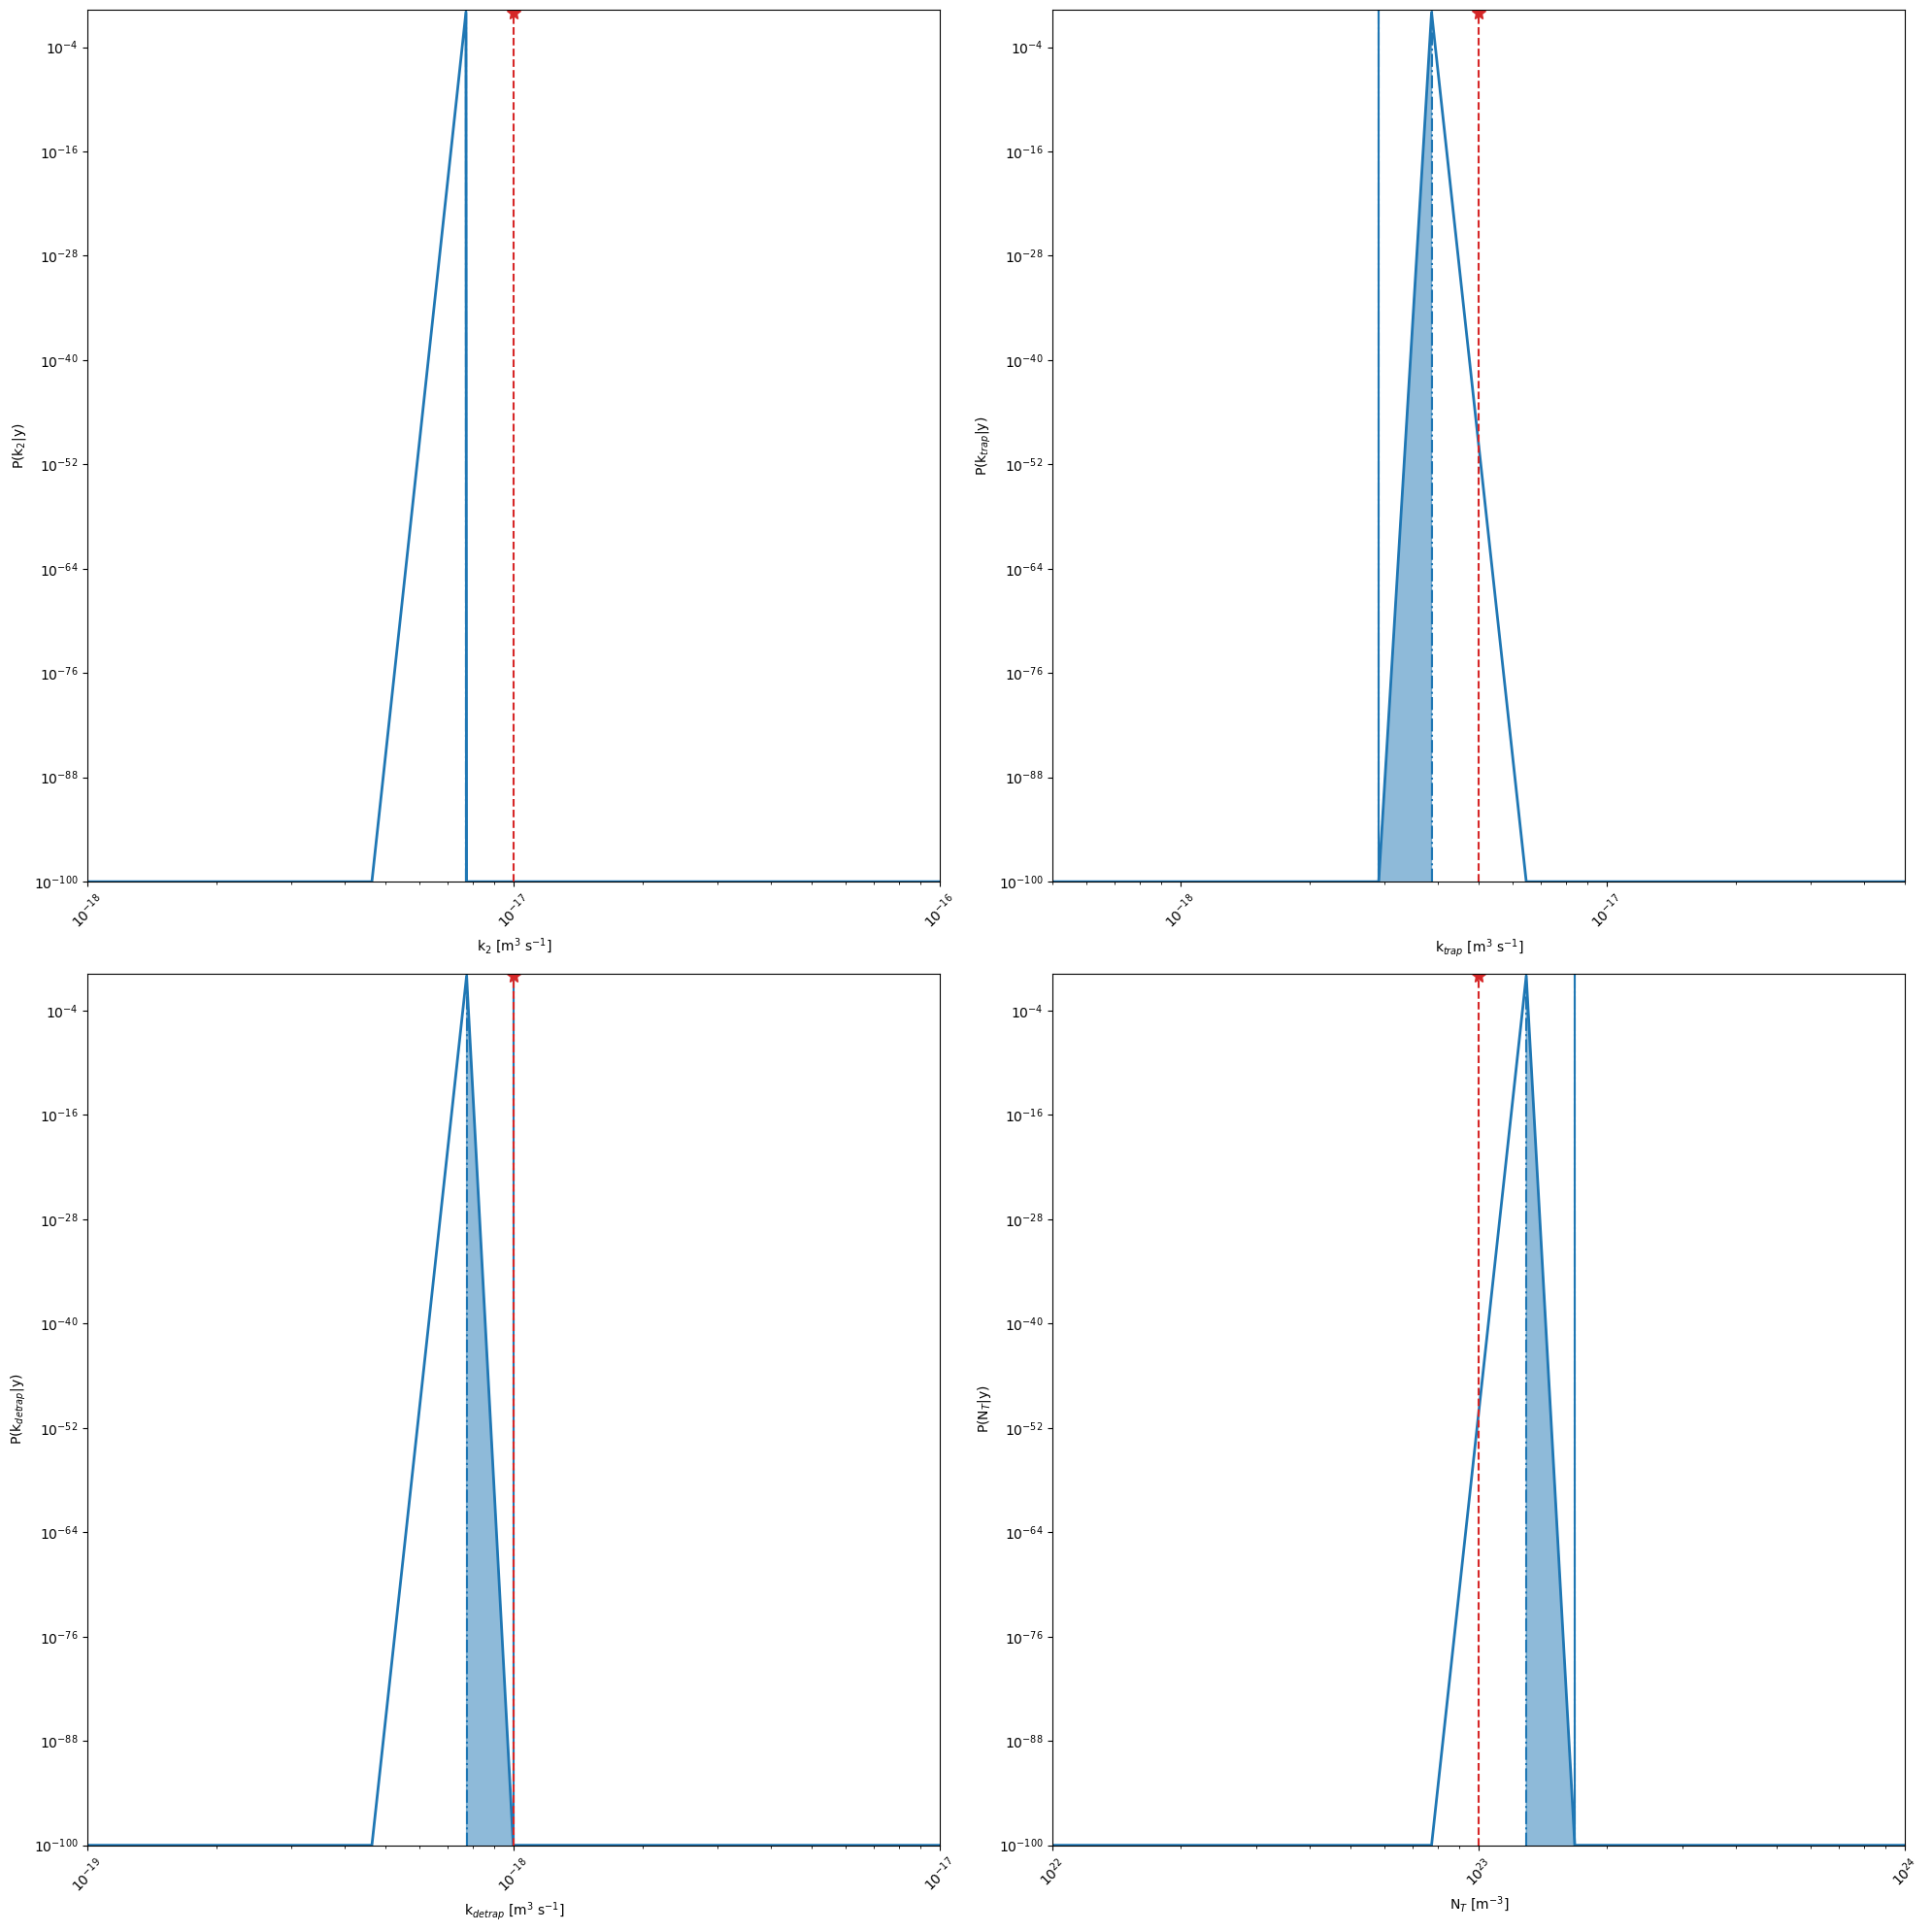

In [5]:
# start multiobjective optimization
X_dimensions = ['t','Gfrac']
y_dimension = 'PL [a.u.]'
target = {'model':partial(trPL.trPL,X_dimensions=X_dimensions,take_log=True), 'target_name':'trPL',
          'data':{'X':X,'y':y,'X_dimensions':X_dimensions,'X_units':['s',''],'y_dimension':y_dimension,'y_unit':''}
            ,'weight':weight,'target_weight':1}

targets = [target]
mo = MultiObjectiveOptimizer(targets = targets, params=params, res_dir=res_dir)

# define the optimization parameters
n_jobs = 4 
n_jobs_init = 20 
n_yscale= 20 
n_initial_points = 80 
n_BO = 150
n_BO_warmstart = 60 

mo.warmstart = 'None' # whether to use warmstart to recall or collect points or not
mo.SaveOldXY2file = os.path.join(res_dir,'old_XY.json') # path to the file where old points are saved
mo.Path2OldXY = os.path.join(res_dir,'old_XY.json') # path to the file where old points are saved
kwargs = {'check_improvement':None,'max_loop_no_improvement':10,'xtol':1e-3,'ftol':1e-3}
kwargs_posterior = {'Nres':10,'Ninteg':1e5,'logscale':True,'vmin':1e-100,'zoom':0,'min_prob':1e-40,'clear_axis':False,'show_points':True,'savefig':True,'figname':'param_posterior','True_values':True_values}
kwargs_plot_obj = {'zscale':'linear'}

r = mo.optimize_sko_parallel(n_jobs=n_jobs,n_yscale=n_yscale, n_BO=n_BO, n_initial_points = n_initial_points,n_BO_warmstart=n_BO_warmstart,n_jobs_init=n_jobs_init,kwargs=kwargs,verbose=False,loss='linear',threshold=1000,base_estimator = 'GP',show_objective_func=False,show_posterior=True,kwargs_posterior = kwargs_posterior,kwargs_plot_obj=kwargs_plot_obj)



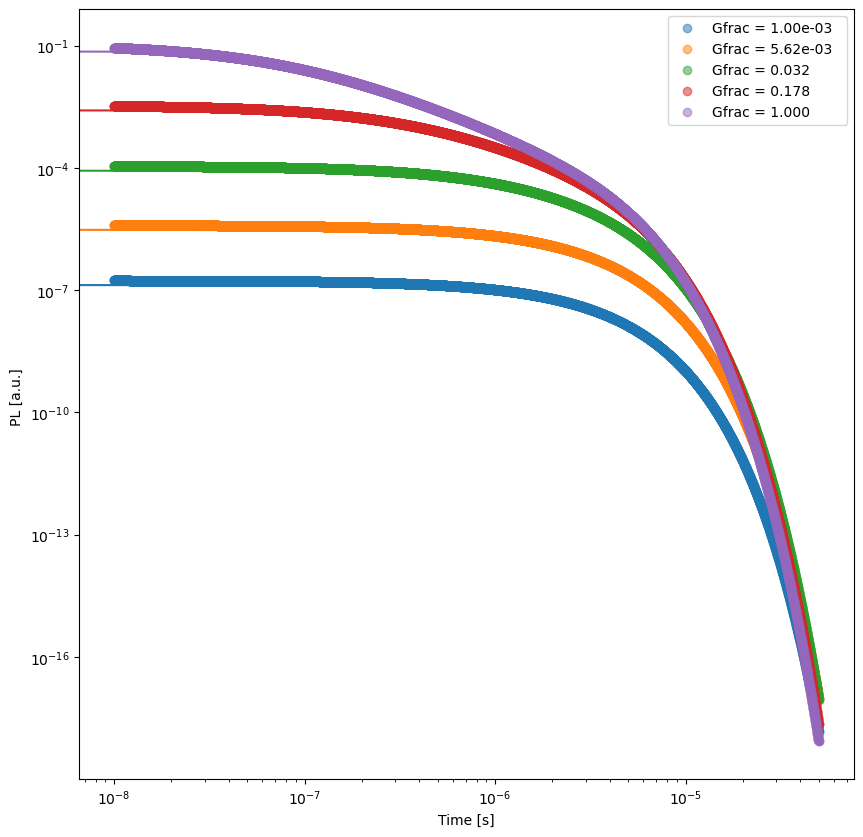

In [6]:
# Plot and save the results
fit_results = []
kwargs_plot_res = {'x_scaling':1,'xaxis_label':'Time [s]','xscale_type':'log','yscale_type':'log','norm_data':False,'delog':True,'figsize':(10,10)}

for num,t in enumerate(targets):
    kwargs_plot_res['figname'] = os.path.join(res_dir,t['target_name']+f'_fit_{num}')
    trPL.plot_fit_res(t,mo.params,'t',xlim=[],ylim=[],kwargs=kwargs_plot_res)

    X = t['data']['X']
    y = t['data']['y']
    X_dimensions = t['data']['X_dimensions']
    yfit = t['model'](X,params,X_dimensions=X_dimensions) # get the best fits

    data = np.concatenate((X, y.reshape(len(y),1), yfit.reshape(len(yfit),1)), axis=1)
    fit_results.append(data)

# prepare the data for saving
param_dict = trPL.get_param_dict(mo.params) # get fitparameters (and fixed ones)

pout = [[f'{v:.3E}' if isinstance(v,float) else v for _,v in pp.items()] for pp in param_dict]

save_output = False
if save_output:
    # produce output excel file with data, fitparameters and FOMs
    fn_xlsx = 'fits_results.xlsx'
    namecols = X_dimensions + ['Jexp','Jfit']
    # delete old file if it exists
    if os.path.exists(os.path.join(res_dir,fn_xlsx)):
        os.remove(os.path.join(res_dir,fn_xlsx))

    with pd.ExcelWriter(os.path.join(res_dir,fn_xlsx), mode='w') as writer:
        for i,t in enumerate(targets):
            if 'target_name' in t.keys():
                tname = t['target_name']
            else: 
                tname = 'data'
            namecols = X_dimensions + [tname+'_exp',tname+'_fit']
            df = pd.DataFrame(fit_results[i],columns=namecols)
            df.to_excel(writer, sheet_name = tname+f'_{i}')
        
        df = pd.DataFrame(pout,columns=[k for k in param_dict[0].keys()])
        df.to_excel(writer, sheet_name = f'params')


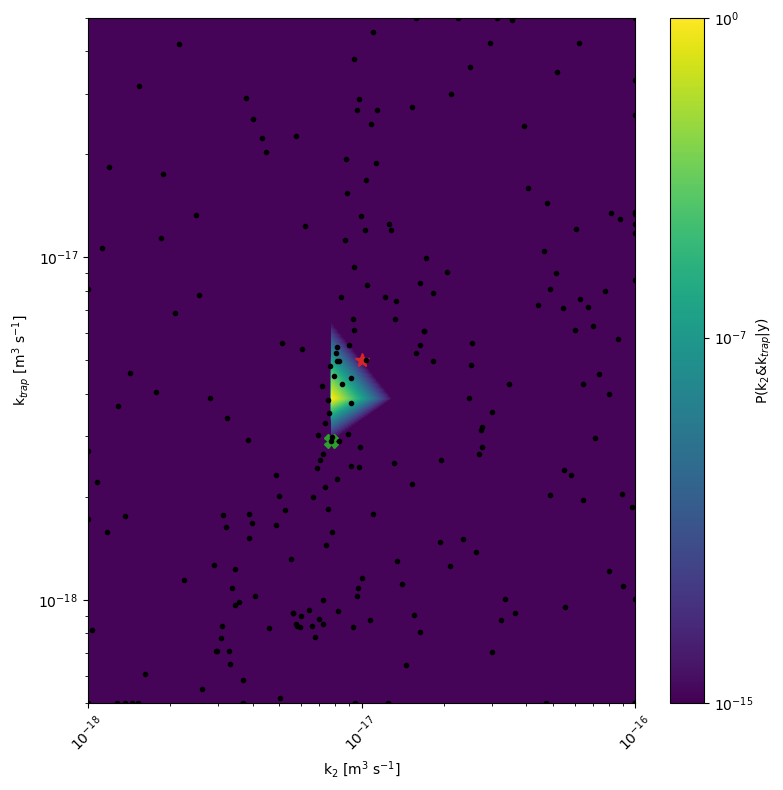

In [7]:
mo.marginal_posterior_2D('kdirect', 'ktrap', Nres=10, Ninteg=1e5, logscale=True,points=mo.points, True_values=True_values,vmin=1e-15)

In [8]:
# Clean output files from simulation folders
from boar.SIMsalabim_utils.CleanFolder import *
Do_Cleaning = False # Careful, this will delete all files in the folder
if Do_Cleaning:
    # delete old_xy.json file if it exists
    # os.remove(mo.path2oldxy) # remove the old_xy.json file if it exists
    # delete warmstart folder if it exists
    if os.path.exists(os.path.join(os.getcwd(),'warmstart/')):
        shutil.rmtree(os.path.join(os.getcwd(),'warmstart/'))
    # delete temp folder if it exists
    if os.path.exists(os.path.join(os.getcwd(),'temp/')):
        shutil.rmtree(os.path.join(os.getcwd(),'temp/'))
